In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.preprocessing import Imputer
from difflib import SequenceMatcher
import seaborn as sns
from statistics import mean 
from ast import literal_eval
from scipy import stats

### An Overview of Fukushima Human Repopulation Project 
---
This projects aims to assess whether areas contaminated by the Fukushima Daiichi Nuclear Disaster are safe for human repopulation. To make this assessment, we've trapped over 200 wild boar roaming the contaminated areas around Fukushima, to use as mammalian proxies for humans. By measuring and analyzing number of biological metrics on these boar, we can determine their levels of radiation exposure and determine to what extent, if any, this exposure has compromised their health. In doing so, we assess the degree of risk for humans to repopulate the areas.

Biomarkers we'll evaluate for the boar include:

Telomere Length of blood & T-cells &nbsp;   
Cortisol levels &nbsp;   
Dicentric chromosomes &nbsp;  
External / internal doses &nbsp;  
Psuedo-pelger Hewitt Anomalies &nbsp;  

The data collected for this project was accumulated over >4 years by a number of graduate students and with support from many PIs. I'm responsible for merging and analyzing all this data into a cohesive story.

In [5]:
for file in os.scandir('./excel data/'):
    if 'boar snake master template' in file.name:
        try:
            ### Make dataframe from Excel file containing Fukushima boar data from Aryn
            df = pd.read_excel(file, sheet_name=0)
            
            ###And a dataframe for Fukushima snake data from Aryn
            snake_df = pd.read_excel(file, sheet_name=1)
            print('success loading Fukushima data as " df and snake_df "')
        
        except:
            print(f'error loading boar/snake data...OTHER files {file.name}')
            
    if 'boar cortisol' in file.name:
        try:
            ###Make dataframe from cortisol values; some shared sample IDs with the boar df
            cortisol_df = pd.read_excel(file, sheet_name=0)
            print('success loading boar cortisol data as " cortisol_df "')
        except:
            print(f'error loading cortisol data...{file.name}')

success loading boar cortisol data as " cortisol_df "
success loading Fukushima data as " df and snake_df "


In [6]:
# df[['Cortisol', 'Sex', 'Age']]
# display(
# df.head(),
# df.describe(),)

In [7]:
ls

00 Fukushima Human Repopulation Project Data Extraction.ipynb
00 Fukushima Human Repopulation Project.ipynb
Fukushima Data Strategy.ipynb
LICENSE
README.md
excel data/
fukushima_telomere_methods.py
misc files/
requirements.txt


In [8]:
df.head(3)

,Exposure Status,Sample ID,Sex,Age,Age Class,Estimated Age (months),External Dose (uSv),Internal Dose (uSv),qPCR ID,Concentration (ng/mcL),260/280,Normalized T/A Average (Average Telomere Length),Cortisol,Dicentrics (TC-FISH),PH anomalies
0,Control,180526C3,M,NaN,Yearling,15,0.38,NaN,C1,14.5,1.90,0.910559,NaN,NaN,NaN
1,Control,180528C2,F,NaN,Juv,8,-,NaN,C2,17.3,1.73,0.985085,NaN,NaN,NaN
2,Control,180604C2,F,NaN,Yearling,18,0.46,NaN,C3,15.8,1.90,1.117980,NaN,NaN,NaN


In [9]:
snake_df.head(3)

,Sample ID,Concentration (ng/mcL),260/280,Sex,External Dose (uSv),Internal Dose (uSv),Telomere Length
0,CEC10,19.3,1.96,F,0.10,NaN,0.444298
1,CEC18,63.7,1.83,F,0.16,NaN,0.826190
2,CEC22,45.5,1.88,F,0.17,NaN,2.067214


In [10]:
cortisol_df.head(3)

,Biel #,Date Received,Sample Number (electronic sheet),Sample ID,Hair wt (mg),Cortisol (pg/mg),Re-run,MeOH Color,pH optimal for assay,Hair Type,Hair Length (cm),Color,Comments,"Worked on sample, but not able to process",Hair Took Extra Time,Repeats
0,1,43518,160804-1,160804-1,17.19,22.990111,N,N,normal,"course, short",3.81,black scalp and tip ends with tan middle,0,0,0,0
1,2,43518,161215 T-1,161215 T-1,25.28,29.120000,N,N,normal,course with split ends,5.02,black with tan tips and scalp end,0,0,0,0
2,3,43518,161215 T-2,161215 T-2,15.85,27.255521,N,N,normal,course with split ends,5.88,black with brown tips,0,0,0,0


In [11]:
### Initial pass at cleaning boar data ' df ' from aryn 

# Cleaning boar data, making missing values NaN
df = df.replace('-', np.NaN)

# CREATE NUMERICAL REPRESENTATIONS, ALA DUMMY VARIABLES, OF EXPOSURE STATUS .. homogenize sample ids
dummies = pd.get_dummies(df['Exposure Status'], prefix='Encoded', drop_first=True)
df['Encoded Exposed'] = dummies['Encoded_Exposed']

# this function cleans 'Sample ID's by removing whitespace & dashes
def remove_dashes_space_sampleIDs(df):
    sample_id_cleaned = []
    for row in df['Sample ID']:
        if '-' in str(row):
            row = str(row).replace('-', '').replace(' ', '')
            sample_id_cleaned.append(row)
        elif ' ' in str(row):
            row = str(row).replace(' ', '')
            sample_id_cleaned.append(row)
        elif row == 'nan':
            continue
        else:
            sample_id_cleaned.append(str(row))
            continue
    return sample_id_cleaned

# cleaning 'Sample ID'
df['Sample ID'] = remove_dashes_space_sampleIDs(df)

In [42]:
### Preparing to merge cortisol data values w/ sample IDs in main boar df 

cortisol_df_samples = pd.DataFrame(cortisol_df['Sample ID'])
cortisol_df_samples['Sample Number (electronic sheet)'] = cortisol_df['Sample Number (electronic sheet)']
cortisol_df_samples['Cortisol (pg/mg)'] = cortisol_df['Cortisol (pg/mg)']

cortisol_df_samples.iloc[14, 0] = cortisol_df_samples.iloc[14,1]
cortisol_df_samples['Sample ID'] = cortisol_df_samples['Sample ID'].astype('str')

### CLEANING SAMPLE IDs IN CORTISOL DATA
        
cortisol_df_samples['Sample ID'] = remove_dashes_space_sampleIDs(cortisol_df)

### MERGING CORTISOL DATA W/ BOAR DATA via SAMPLE ID

merged_df_cortisol = df.merge(cortisol_df_samples, on=['Sample ID'])
aryn_teloPCR_cort_rad = merged_df_cortisol.drop(axis=1, labels=['Concentration (ng/mcL)','260/280', 'qPCR ID', 'Cortisol'])

In [43]:
### Making radiation exposure status of snakes more readable

def readable_snake_df_dummy_variables(snake_df):

    Exposure_Status = []
    for row in snake_df['Sample ID']:
        if row.startswith('C'):
            Exposure_Status.append('Control')
        elif row.startswith('E'):
            Exposure_Status.append('Exposed')
    snake_df['Exposure Status'] = Exposure_Status

    ### making dummy variables for snake exposure status
    snake_dum = pd.get_dummies(snake_df['Exposure Status'], prefix='Encoded', drop_first=True)
    snake_df['Encoded Exposed'] = snake_dum
    
    return snake_df

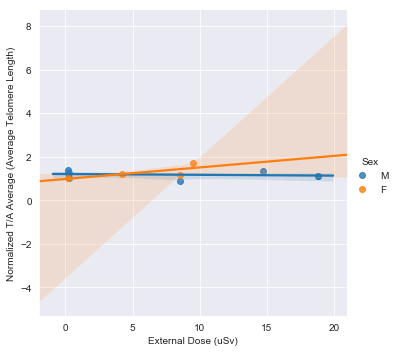

In [51]:
sns.lmplot(x='External Dose (uSv)', y='Normalized T/A Average (Average Telomere Length)', hue='Sex',data=aryn_teloPCR_cort_rad)

In [13]:
# aryn_teloPCR_cort_rad

In [14]:
# snake_df.head()

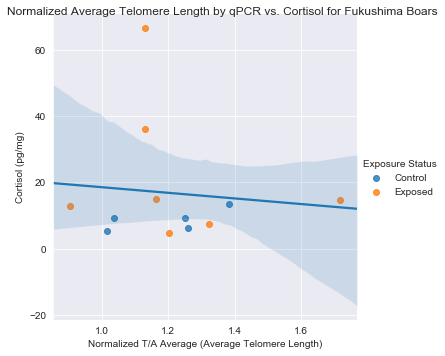

In [13]:
sns.set_style('darkgrid')
#Use lmplot to plot scatter points
# Create lmplot
ag = sns.lmplot(x='Normalized T/A Average (Average Telomere Length)', y='Cortisol (pg/mg)', hue='Exposure Status', 
                data=aryn_teloPCR_cort_rad, fit_reg=False)

# Access the figure & add title
fig = ag.fig
fig.suptitle("Normalized Average Telomere Length by qPCR vs. Cortisol for Fukushima Boars", fontsize=12)

#Use regplot to plot the regression line for the whole points
sns.regplot(x='Normalized T/A Average (Average Telomere Length)', y='Cortisol (pg/mg)', 
            data=aryn_teloPCR_cort_rad, scatter=False, ax=ag.axes[0, 0])

# plt.savefig(f'Normalized Average Telomere Length by qPCR vs. Cortisol for Fukushima Boars.pdf')

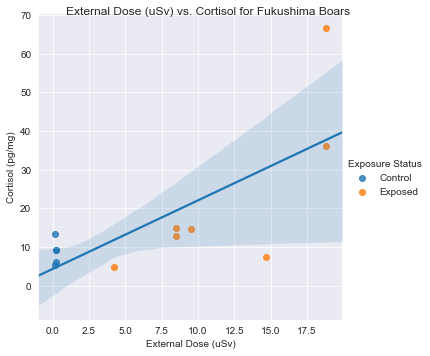

In [15]:
#Use lmplot to plot scatter points
#Use regplot to plot the regression line for the whole points
# Create lmplot
ag = sns.lmplot(x='External Dose (uSv)', y='Cortisol (pg/mg)', hue='Exposure Status', 
                data=aryn_teloPCR_cort_rad, fit_reg=False)
# Access the figure
fig = ag.fig

# Add title to Figure
fig.suptitle("External Dose (uSv) vs. Cortisol for Fukushima Boars", fontsize=12)

sns.regplot(x='External Dose (uSv)', y='Cortisol (pg/mg)', 
            data=aryn_teloPCR_cort_rad, scatter=False, ax=ag.axes[0, 0])

plt.savefig(f'External Dose (uSv) vs. Cortisol for Fukushima Boars.pdf')


In [ ]:
sns.lmplot(x='')

Sex  Exposure Status
F    Control             5
     Exposed            13
M    Control             8
     Exposed            20
dtype: int64

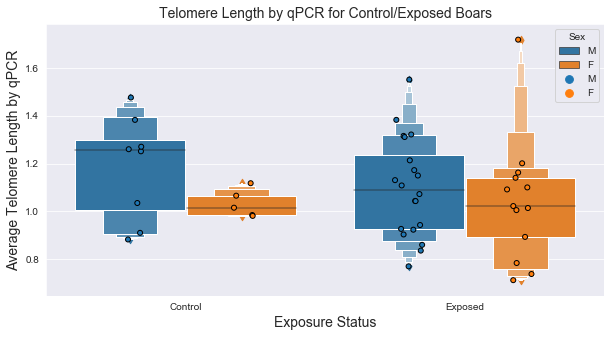

In [48]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10,5))
ax = sns.boxenplot(x='Exposure Status', y='Normalized T/A Average (Average Telomere Length)', hue='Sex', data=df)
ax = sns.stripplot(x='Exposure Status', y='Normalized T/A Average (Average Telomere Length)', hue='Sex', data=df, 
                   dodge=True, edgecolor='black', linewidth=1)
ax=fig.gca()
ax.set_title('Telomere Length by qPCR for Control/Exposed Boars', fontsize=14)
ax.set_xlabel('Exposure Status', fontsize=14)
ax.set_ylabel('Average Telomere Length by qPCR', fontsize=14)

df.groupby(by=['Sex', 'Exposure Status']).size()

#GREATER EFFECT OF RADIATION ON FEMALE BOAR? sample size?


In [52]:
### Next.. let's work on grabbing Kelly's telomere length by Fluoresence Intensity Hybridiziation (FISH) files

# This function allows us to rescue telomere signals lost during the telomere FISH imaging / quantification process.
# where telomeres (both long & short) are lost at random. This function randomly samples observed telomere length values
# up to the maximum theoretical number of telos, given n # of cells & # telos per cell 

def gen_missing_values_andimpute_or_randomsampledown(n_cells, telosPercell, df):
    
    max_telos = n_cells * telosPercell
    half_telos = (n_cells * telosPercell) / 2

    if df.size > max_telos:
        df_sampled = df.sample(max_telos)
        return df_sampled

    if df.size > 25 and df.size <= half_telos:
        missing_data_difference = abs( (n_cells * telosPercell) - df.size )
        rsampled = df.sample(missing_data_difference, replace=True, random_state=28)
        concat_ed = pd.concat([rsampled, df], sort=False)
        np.random.shuffle(concat_ed.to_numpy())
        return concat_ed

    if df.size > 25 and df.size < max_telos:
        missing_data_difference = abs( (n_cells * telosPercell) - df.size )
        rsampled = df.sample(missing_data_difference, random_state=28)
        concat_ed = pd.concat([rsampled, df], sort=False)
        np.random.shuffle(concat_ed.to_numpy())
        return concat_ed
    
    else:
        return df

# axis labels of values within the telomere length excel values that are NOT
# telomere length values 
labels=[6, 172, 338, 504, 670, 836, 1002, 1168, 1334, 1500, 1666, 1832, 
1998, 2164, 2330, 2496, 2662, 2828, 2994, 3160, 3326, 3492, 3658, 3824,
3990, 4156, 4322, 4488, 4654, 4820]

labels_offset_by6 = [(x-6) for x in labels]

def clean_individ_telos(telo_data):
    telo_data = telo_data.drop(labels_offset_by6)
    telo_data = pd.to_numeric(telo_data.iloc[:,0], errors='coerce')
    telo_data = telo_data.dropna(axis=0, how='any')
    telo_data = telo_data.to_frame(name=None)
    telo_data = telo_data[(np.abs(stats.zscore(telo_data)) < 3).all(axis=1)]
    telo_data = pd.Series(telo_data.iloc[:,0])
    telo_data = gen_missing_values_andimpute_or_randomsampledown(30, 160, telo_data)
    telo_data.reset_index(drop=True, inplace=True)
    return telo_data

In [17]:
# FUNCTION FOR PULLING KELLY'S TELOFISH DATA FOR 40 BOARS into a LIST.. TO BE MADE INTO A DATAFRAME & JOINED W/ MAIN DATAFRAME if possible
# These excel files take forever to load.. the objective here is to synthesize all the excel files for 
# telomere FISH data into one dataframe, then save that dataframe to csv file to be retrieved later
# loading one whole csv file containing all the data will be much, much faster than loading the parts of the whole 
# Along the way, we'll normalize the teloFISH data using controls internal to each excel file

def extract_boar_teloFISH_as_list(path):
    boar_teloFISH_list = []
    for file in os.scandir(path):
        if 'Hyb' in file.name:
            print(f'Handling {file.name}...')
            telo_excel_dict = pd.read_excel(file.name, sheet_name=None, skiprows=4, usecols=[3], nrows=5000)
            if 'Telomere Template' in telo_excel_dict.keys():
                del telo_excel_dict['Telomere Template']

            excel_file_list = []
            for sample_id, telos in telo_excel_dict.items():
                telos_cleaned = clean_individ_telos(telos)

                if sample_id != 'Control': 
                    excel_file_list.append([sample_id, telos_cleaned.values, np.mean(telos_cleaned)]) 
                elif sample_id == 'Control':
                    control_value = np.mean(telos_cleaned)

            
            #normalize teloFISH values by control value 
            for sample in excel_file_list:
                #normalize individual telos
                sample[1] = np.divide(sample[1], control_value)
                
                #normalize telo means
                sample[2] = np.divide(sample[2], control_value)
                boar_teloFISH_list.append(sample)
#                 print(f'{sample[0]} finished..')
            
    print('Finished collecting boar teloFISH data')
    return boar_teloFISH_list


In [18]:
boar_teloFISH_list = extract_boar_teloFISH_as_list('.')

Handling Telomeres - Fukushima Hyb 4 complete.xlsx...
Handling Telomeres - Fukushima Hyb 3 complete.xlsx...
Handling Telomeres - Fukushima Hyb 6 completed.xlsx...
Handling Meredith -- Telomeres - Fukushima Hyb 2.xlsx...
Handling Telomeres - Fukushima Hyb 1 complete.xlsx...
Handling Telomeres - Fukushima Hyb 5 complete.xlsx...
Finished collecting boar teloFISH data


In [53]:
### putting all of kelly's boar telomere FISH data into one dataframe
initial_boar_teloFISH_df = pd.DataFrame(boar_teloFISH_list, columns=['Sample ID', 'TeloFISH telos', 'TeloFISH Means'])

# turning the teloFISH data, which is a series in each row containing 4800 individial telomere lengths, 
# into a list in each row so that it's saved & loaded properly
# *** saving/loading teloFISH data as dataframe, series, or np.array was throwing issues w/ data integrity
initial_boar_teloFISH_df['TeloFISH telos'] = initial_boar_teloFISH_df['TeloFISH telos'].apply(lambda row: row.tolist())

# saving data to csv file for later retrieval
copy = initial_boar_teloFISH_df
copy.to_csv('boar_teloFISH.csv')
boar_teloFISH_df = pd.read_csv('boar_teloFISH.csv', index_col=0)

In [54]:
# retrieving data & returning teloFISH data to np.arrays from lists using literal eval
boar_teloFISH_df = pd.read_csv('boar_teloFISH.csv', index_col=0)
boar_teloFISH_df['TeloFISH telos'] = boar_teloFISH_df['TeloFISH telos'].apply(lambda row: np.array(literal_eval(row)))

In [12]:
# boar_teloFISH_df

In [56]:
def remove_dashes_space_sampleIDs(df):
    sample_id_cleaned = []
    for row in df['Sample ID']:
        if '-' in row:
            row = row.replace('-', '').replace(' ', '')
            sample_id_cleaned.append(row)
        elif ' ' in row:
            row = row.replace(' ', '')
            sample_id_cleaned.append(row)
        else:
            sample_id_cleaned.append(row)
            continue
    return sample_id_cleaned

boar_teloFISH_df['Sample ID'] = remove_dashes_space_sampleIDs(boar_teloFISH_df)

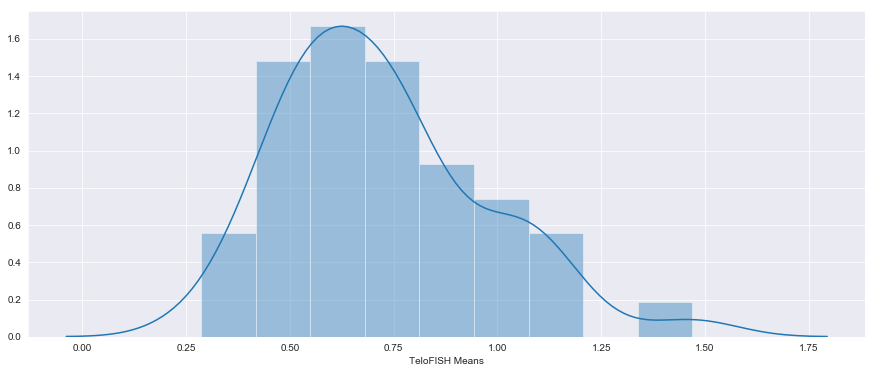

In [37]:
fig = plt.figure(figsize=(15,6))
sns.set_style('darkgrid')
sns.distplot(boar_teloFISH_df['TeloFISH Means'], bins=9)

# sns.barplot(y='Sample ID', x='TeloFISH Means', data=boar_teloFISH_df)

# ax=fig.gca()

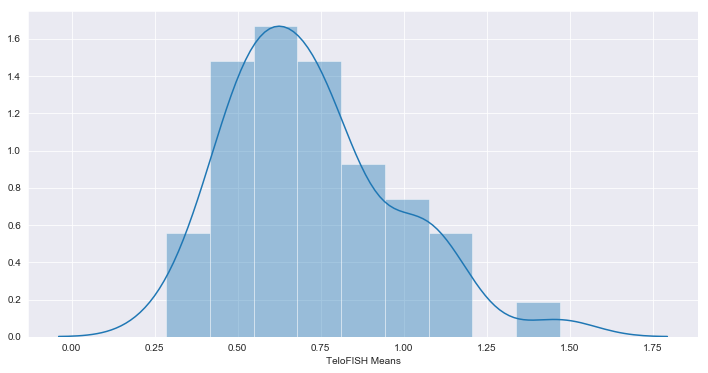

In [38]:
fig = plt.figure(figsize=(12,6))
sns.distplot(boar_teloFISH_df['TeloFISH Means'], bins=9)

ax=fig.gca()

In [78]:
boar_teloFISH_df.sort_values(by=['Sample ID'], axis=0)

,Sample ID,TeloFISH telos,TeloFISH Means
33,1606101,"[0.27734319442469063, 0.2506755795761627, 0.40...",0.401069
22,1606102,"[1.0719071013845467, 0.8932559178204555, 1.098...",1.174770
0,1606103,"[0.39656588835180795, 0.9215967827894128, 0.27...",0.439557
1,1607205,"[0.3909804533045994, 0.1619776163690483, 0.167...",0.452469
2,1607221,"[0.48034741405993636, 0.5026891542487706, 0.62...",0.533217
3,1607231,"[0.3462969729269309, 0.4524202388238936, 0.815...",0.583101
32,1607261,"[0.5866875266676148, 0.32534490115204096, 0.82...",0.555020
4,1607262,"[0.7707900365147816, 0.843400692128493, 0.8154...",0.838296
26,1607263,"[1.839445519659901, 2.2298314392999523, 0.8932...",1.469960
7,1607264,"[1.1564424209946866, 0.7919878398327247, 0.308...",0.755637


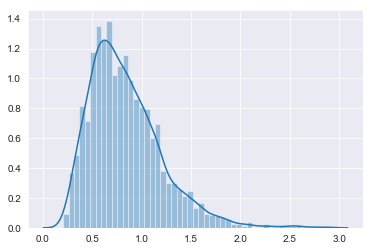

In [79]:
sns.distplot(boar_teloFISH_df['TeloFISH telos'][4])

In [57]:
### MERGING KELLY TELOFISH DATA W/ CORTISOL DATA
kelly_teloF_cort = boar_teloFISH_df.merge(cortisol_df_samples, on=['Sample ID'])

# !nice! have some hits
print(kelly_teloF_cort.shape)
kelly_teloF_cort.corr()

(18, 5)


,TeloFISH Means,Cortisol (pg/mg)
TeloFISH Means,1.000000,0.631531
Cortisol (pg/mg),0.631531,1.000000


In [58]:
kelly_teloF_cort

,Sample ID,TeloFISH telos,TeloFISH Means,Sample Number (electronic sheet),Cortisol (pg/mg)
0,1607262,"[0.6758376407122361, 0.8824987374589529, 0.564...",0.838296,160726-2,7.087576
1,1607281,"[0.6311541603345676, 0.3909804533045994, 0.301...",0.413094,160728-1,5.445329
2,1607264,"[0.8901102270686375, 0.9251539367957492, 1.815...",0.755637,160726-4,5.360000
3,1611301O210,"[0.2873584197623161, 0.735917904269346, 0.5046...",0.589711,161130-1 O-210 collar,17.120000
4,1611302O211,"[1.0372938079225067, 0.3294108714348501, 0.210...",0.679410,161130-2 O-211,5.477178
5,161215T1,"[0.8690840012323705, 1.1704599048855313, 0.784...",1.084547,161215 T-1,29.120000
6,161215T1,"[0.8690840012323705, 1.1704599048855313, 0.784...",1.084547,161215 T-1,30.253737
7,161215T2,"[2.3969897453344413, 1.3176434857394004, 0.686...",1.054018,161215 T-2,27.255521
8,161215T2,"[2.3969897453344413, 1.3176434857394004, 0.686...",1.054018,161215 T-2,23.796954
9,161206O231,"[0.41878745832881853, 0.148602001342484, 1.101...",0.517598,161206 O-231,29.600000


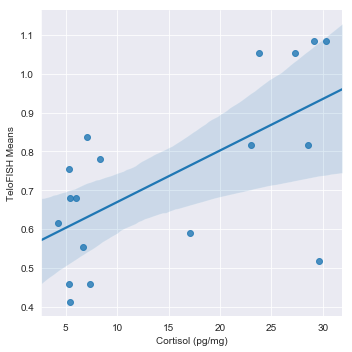

In [42]:
sns.lmplot(y='TeloFISH Means', x='Cortisol (pg/mg)', data=kelly_teloF_cort)

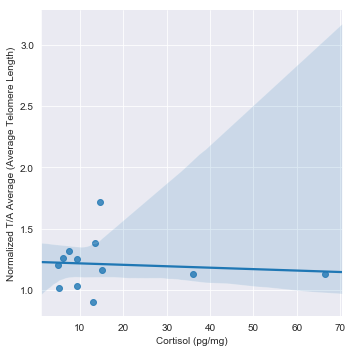

In [43]:
sns.lmplot(y='Normalized T/A Average (Average Telomere Length)', x='Cortisol (pg/mg)', data=aryn_teloPCR_cort_rad)

In [879]:
df.head()

,Exposure Status,Sample ID,Sex,Age,Age Class,Estimated Age (months),External Dose (uSv),Internal Dose (uSv),qPCR ID,Concentration (ng/mcL),260/280,Normalized T/A Average (Average Telomere Length),Cortisol,Dicentrics (TC-FISH),PH anomalies,Encoded Exposed
0,Control,180526C3,M,NaN,Yearling,15.0,0.38,NaN,C1,14.5,1.90,0.910559,NaN,NaN,NaN,0
1,Control,180528C2,F,NaN,Juv,8.0,NaN,NaN,C2,17.3,1.73,0.985085,NaN,NaN,NaN,0
2,Control,180604C2,F,NaN,Yearling,18.0,0.46,NaN,C3,15.8,1.90,1.117980,NaN,NaN,NaN,0
3,Control,180612C1,M,NaN,Yearling,15.0,0.27,NaN,C4,13.1,1.60,1.260040,NaN,NaN,NaN,0
4,Control,180627C1,M,NaN,Juv+,10.0,0.32,NaN,C5,6.2,1.70,1.476052,NaN,NaN,NaN,0


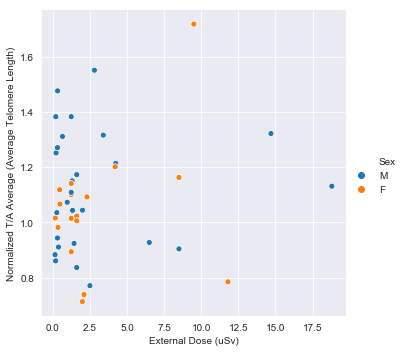

In [44]:
sns.relplot(x='External Dose (uSv)', y='Normalized T/A Average (Average Telomere Length)', hue='Sex', data=df)

In [59]:
### ACQUIRING KELLY DICENTRIC DATA

kelly_dicentrics = pd.read_excel('Fukushima Dicentrics.xlsx')
kelly_dicentrics.rename(columns={'Pig ID': 'Sample ID'}, inplace=True)
   
kelly_dicentrics['Sample ID'] = remove_dashes_space_sampleIDs(kelly_dicentrics)
kelly_dicentrics['Dicentrics per 100 Cells'] = kelly_dicentrics['Dicentrics']/kelly_dicentrics['Total Scored']
kelly_dicentrics.drop(['Dicentric Images', 'Notes', 'Dicentrics', 'Total Scored'], axis=1, inplace=True)



In [15]:
print(kelly_dicentrics.shape)
# kelly_dicentrics.sort_values(by=['Sample ID'], axis=0)
# kelly_dicentrics

NameError: name 'kelly_dicentrics' is not defined

In [74]:
### MERGE KELLY TELOFISH DATA W/ DICENTRICS

kelly_teloF_dicent = boar_teloFISH_df.merge(kelly_dicentrics[['Sample ID', 
                                                              'Dicentrics per 100 Cells']], on=['Sample ID'])
print(kelly_teloF_dicent.shape)
kelly_teloF_dicent

(40, 4)


,Sample ID,TeloFISH telos,TeloFISH Means,Dicentrics per 100 Cells
0,1606103,"[0.2848571874076367, 0.12846500608579695, 0.39...",0.439557,0.00000
1,1607205,"[0.3909804533045994, 0.7093502509954874, 0.485...",0.452469,0.00000
2,1607221,"[0.7205211210899046, 0.7428628612787388, 0.245...",0.533217,0.01000
3,1607231,"[0.3016134925492624, 0.3630532780685566, 0.485...",0.583101,0.01000
4,1607262,"[0.6758376407122361, 0.8824987374589529, 0.564...",0.838296,0.01000
5,1607281,"[0.6311541603345676, 0.3909804533045994, 0.301...",0.413094,0.02000
6,1608013,"[0.625568725287359, 0.5362017645320221, 0.3016...",0.537292,0.02000
7,1607264,"[0.8901102270686375, 0.9251539367957492, 1.815...",0.755637,0.00000
8,1611301O210,"[0.2873584197623161, 0.735917904269346, 0.5046...",0.589711,0.03000
9,1611302O211,"[1.0372938079225067, 0.3294108714348501, 0.210...",0.679410,0.01000


In [ ]:
kelly

,TeloFISH Means,Dicentrics per 100 Cells
TeloFISH Means,1.000000,-0.217554
Dicentrics per 100 Cells,-0.217554,1.000000


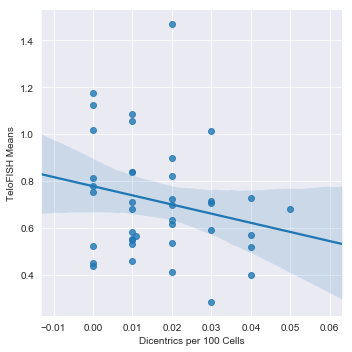

In [65]:
sns.lmplot(x='Dicentrics per 100 Cells', y='TeloFISH Means', data=kelly_teloF_dicent)
kelly_teloF_dicent.corr()

In [67]:
### MERGE KELLY DICENTRICS W/ MERGED TELOFISH + CORTISOL DATA

kelly_teloF_dicent_cort = kelly_dicentrics.merge(kelly_teloF_cort, on=['Sample ID'])
kelly_teloF_dicent_cort.drop(['Sample Number (electronic sheet)'], axis=1, inplace=True)

In [68]:
print(kelly_teloF_dicent_cort.shape)
kelly_teloF_dicent_cort.head(3)

(18, 5)


,Sample ID,Dicentrics per 100 Cells,TeloFISH telos,TeloFISH Means,Cortisol (pg/mg)
0,1607261,0.01,"[0.2400085336367515, 0.4480159294552695, 0.512...",0.555020,6.736842
1,161216O247,0.01,"[0.6506898023040819, 0.3573460389702745, 0.202...",0.459026,5.360000
2,161216O247,0.01,"[0.6506898023040819, 0.3573460389702745, 0.202...",0.459026,7.394297


In [68]:
kelly_teloF_dicent_cort.corr()

,Dicentrics per 100 Cells,TeloFISH Means,Cortisol (pg/mg)
Dicentrics per 100 Cells,1.000000,-0.350963,-0.054393
TeloFISH Means,-0.350963,1.000000,0.631531
Cortisol (pg/mg),-0.054393,0.631531,1.000000


In [69]:
### ACQUIRING KELLY BOAR AGE, SEX DATA
kelly_age_sex = pd.read_excel('Fukushima Boar Data.xlsx', dtype={'Age (weeks)':str})
kelly_age_sex.rename(columns={'ID': 'Sample ID'}, inplace=True)
cols_keep = ['Sample ID', 'Sex', 'Age (weeks)']
cols_drop = [col for col in kelly_age_sex.columns if col not in cols_keep]

kelly_age_sex.drop(cols_drop, axis=1, inplace=True)
kelly_age_sex.dropna(inplace=True)
kelly_age_sex['Sample ID'] = remove_dashes_space_sampleIDs(kelly_age_sex)

In [70]:
# Need to change estimated boar age in this df from type str to actual numbers
# to accomplish this, we must remove the dashes, compute an average of the estimated age,
# and change the estimation units of weeks to months, then we can merge this info into prior dfs

age_row = []
for row in kelly_age_sex['Age (weeks)']:
    if '-' in row:
        row = row.replace('-', ' ')
        age_row.append(row)
    else:
        age_row.append(row)
        
kelly_age_sex['Age (weeks)'] = age_row

In [71]:
# Estimated Age (months)
age_est_fixed = []
for row in kelly_age_sex['Age (weeks)']:
    if len(row) == 1 or len(row) == 2:
        row = float(row)
        age_est_fixed.append(row)
    elif len(row) == 3 and ' ' in row:
        row = (float(row[2]) + float(row[0])) / 2
        age_est_fixed.append(row)
    elif len(row) == 5:
        row = (float(row[3:5]) + float(row[0:2])) / 2
        age_est_fixed.append(row)
    elif len(row) == 3 and ' ' not in row:
        row = float(row)
        age_est_fixed.append(row)
    else:
        print(row, 'error')
        
kelly_age_sex['Age (weeks)'] = age_est_fixed
kelly_age_sex['Estimated Age (months)'] = kelly_age_sex['Age (weeks)'] / 4
kelly_age_sex.drop(['Age (weeks)'], axis=1, inplace=True)

In [ ]:
def average_age_weeks(df):

    age_row = []
    for row in df['Age (weeks)']:
        if '-' in row:
            row = row.replace('-', ' ')
            age_row.append(row)
        else:
            age_row.append(row)

    df['Age (weeks)'] = age_row
    
    age_est_fixed = []
    
    for row in df['Age (weeks)']:
        if len(row) == 1 or len(row) == 2:
            row = float(row)
            age_est_fixed.append(row)
        elif len(row) == 3 and ' ' in row:
            row = (float(row[2]) + float(row[0])) / 2
            age_est_fixed.append(row)
        elif len(row) == 5:
            row = (float(row[3:5]) + float(row[0:2])) / 2
            age_est_fixed.append(row)
        elif len(row) == 3 and ' ' not in row:
            row = float(row)
            age_est_fixed.append(row)
        else:
            print(row, 'error')
        
    df['Age (weeks)'] = age_est_fixed
    
    return df

In [72]:
kelly_age_sex.head()
kelly_age_sex.shape

(37, 3)

In [73]:
### let's merge kelly's boar teloFISH data with age/sex data.. 
print(f'Age/Sex data shape {kelly_age_sex.shape}', 
      f'\nkelly teloF data shape {boar_teloFISH_df.shape}')

Age/Sex data shape (37, 3) 
kelly teloF data shape (41, 3)


In [73]:
boar_teloFISH_df_age_sex = boar_teloFISH_df.merge(kelly_age_sex, on=['Sample ID'])
boar_teloFISH_df_age_sex

# similarity_score(boar_teloFISH_df, kelly_age_sex)
# not much age / sex data for kelly's boar which have teloFISH data 

,Sample ID,TeloFISH telos,TeloFISH Means,Sex,Estimated Age (months)
0,1606103,"[0.2848571874076367, 0.12846500608579695, 0.39...",0.439557,Male,7.250
1,1607205,"[0.3909804533045994, 0.7093502509954874, 0.485...",0.452469,Male,1.875
2,1607221,"[0.7205211210899046, 0.7428628612787388, 0.245...",0.533217,Male,1.875
3,1607262,"[0.6758376407122361, 0.8824987374589529, 0.564...",0.838296,Male,21.750
4,1607264,"[0.8901102270686375, 0.9251539367957492, 1.815...",0.755637,Female,20.000
5,1606102,"[1.2108580219343954, 0.9726564438489406, 1.065...",1.174770,Female,6.500
6,1607263,"[1.7997452566456587, 1.0785238118869205, 1.865...",1.469960,Male,1.875
7,1607261,"[0.2400085336367515, 0.4480159294552695, 0.512...",0.555020,Female,21.750
8,1606101,"[0.1920068269094012, 0.389347176788508, 0.2080...",0.401069,Male,9.000


In [894]:
### Hmmm.... since not many shared sample IDs between teloF & age/sex data, may have to shelve this for now 
boar_teloFISH_df_age_sex.shape

(9, 5)

In [77]:
boar_teloFISH_df_age_sex

,Sample ID,TeloFISH telos,TeloFISH Means,Sex,Estimated Age (months)
0,1606103,"[0.39656588835180795, 0.9215967827894128, 0.27...",0.439557,Male,7.250
1,1607205,"[0.3909804533045994, 0.1619776163690483, 0.167...",0.452469,Male,1.875
2,1607221,"[0.48034741405993636, 0.5026891542487706, 0.62...",0.533217,Male,1.875
3,1607262,"[0.7707900365147816, 0.843400692128493, 0.8154...",0.838296,Male,21.750
4,1607264,"[1.1564424209946866, 0.7919878398327247, 0.308...",0.755637,Female,20.000
5,1606102,"[1.0719071013845467, 0.8932559178204555, 1.098...",1.174770,Female,6.500
6,1607263,"[1.839445519659901, 2.2298314392999523, 0.8932...",1.469960,Male,1.875
7,1607261,"[0.5866875266676148, 0.32534490115204096, 0.82...",0.555020,Female,21.750
8,1606101,"[0.27734319442469063, 0.2506755795761627, 0.40...",0.401069,Male,9.000


In [ ]:
### MISC. CODE SHELVED FOR NOW

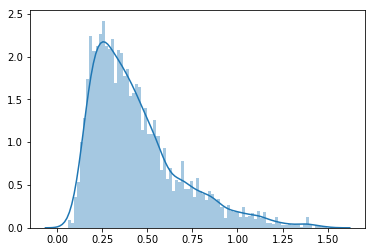

In [16]:
sns.distplot(boar_teloFISH_df['TeloFISH telos'][0], bins=85, hist=True)

# sns.set_style('darkgrid')
# fig = plt.figure(figsize=(15,6)) # define plot area
# g = sns.distplot(boar_teloFISH_df['TeloFISH telos'][4], bins=200, hist=True)
# g.set(xlim=(0, 3))
# g.set(ylim=(0, 2))

In [18]:
type(boar_teloFISH_df['TeloFISH telos'][0])

numpy.ndarray

In [ ]:
# sample_id_cleaned = []
# for row in boar_teloFISH_df['Sample ID']:
#     if '-' in row:
#         row = row.replace('-', '').replace(' ', '')
#         sample_id_cleaned.append(row)
#     else:
#         continue
# # sample_id_cleaned
# boar_teloFISH_df['Sample ID'] = sample_id_cleaned

In [ ]:
### DEPRECATED LINEAR REGRESSION EXAMPLE... PREFER TO USE SEABORN FOR THIS

# ext_dosage = aryn_teloPCR_cort_rad['External Dose (uSv)']
# ext_dosage = ext_dosage.values.reshape(-1, 1)

# cortisol = aryn_teloPCR_cort_rad['Cortisol (pg/mg)']
# cortisol = cortisol.values.reshape(-1, 1)

# linear_reg = linear_model.LinearRegression()
# linear_reg.fit(ext_dosage, cortisol)

# aryn_teloPCR_cort_rad.plot.scatter(x=['External Dose (uSv)'], y=['Cortisol (pg/mg)'])
# # plt.scatter(ext_dosage, cortisol,  color='black')
# plt.plot(ext_dosage, linear_reg.predict(ext_dosage), color='black', linewidth=1)
# # plt.xticks(())
# # plt.yticks(())
# # plt.show()

In [ ]:
### FINDING MISLABELED SAMPLES IN CORTISOL DATA 

#finding mislabeled samples
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def similarity_score(df, df2):
    score_dict = {}

    for row in df['Sample ID']:
        for row2 in df2['Sample ID']:
            score = similar(row, row2)
            score_dict[score] = [row, row2]
    for score, samples in score_dict.items():
        if score >= .5:
            print(samples)
            
# similarity_score(df, cortisol_df_samples)